In [83]:
## IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
# Path of the file to read
NYC_File_Path = 'nyc-rolling-sales.csv'

# Data Cleaning
home_data = pd.read_csv(NYC_File_Path)
home_data = home_data.dropna(axis=0)
home_data = home_data[home_data['LAND SQUARE FEET'] != ' -  ']
home_data = home_data[home_data['SALE PRICE'] != ' -  ']
home_data = home_data[home_data['GROSS SQUARE FEET'] != ' -  ']
home_data=home_data[home_data['YEAR BUILT'] > 10]

# Adding integer type columns
sale_price = pd.to_numeric(home_data['SALE PRICE'], errors='coerce')
land_square_feet = pd.to_numeric(home_data['LAND SQUARE FEET'], errors='coerce')
gross_square_feet = pd.to_numeric(home_data['GROSS SQUARE FEET'], errors='coerce')
home_data['land_square_feet_int'] = land_square_feet
home_data['gross_square_feet_int'] = gross_square_feet
home_data['sale_price_int'] = sale_price

# Removing values of transactions less than $ 1000 (not reflective of true value)
home_data = home_data[home_data['sale_price_int'] > 1000] # removing nonsense values
home_data.columns

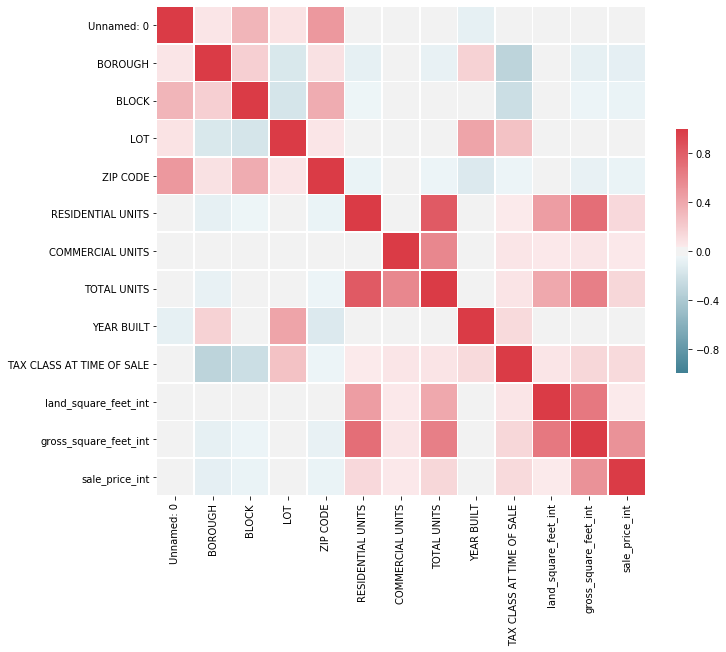

In [85]:
## CORRELATION MATRIX
corr = home_data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

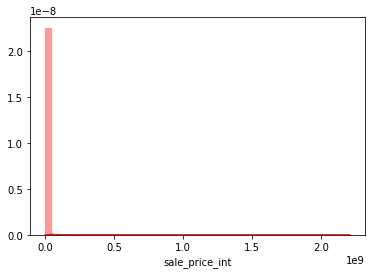

In [86]:
# Whole Dataset sales dist
sns.distplot(home_data['sale_price_int'],color = 'r')

In [87]:
#skewness and kurtosis
print("Skewness: %f" % home_data['sale_price_int'].skew())
print("Kurtosis: %f" % home_data['sale_price_int'].kurt())

Skewness: 97.053197
Kurtosis: 12434.027224


In [88]:
## Lots of outliers, put a price limit to eliminate those, then separate further to residential and commercial data
home_data = home_data[home_data['sale_price_int'] < 4000000]
home_data.to_csv('nyc-rolling-sales-cleaned.csv')

# Creating Residential Dataset
residential_data = home_data[(home_data['TAX CLASS AT TIME OF SALE'] == 1) | (home_data['TAX CLASS AT TIME OF SALE'] == 2)]

# Creating Commercial Dataset
commercial_data = home_data[(home_data['TAX CLASS AT TIME OF SALE'] == 3) | (home_data['TAX CLASS AT TIME OF SALE'] == 4)]
# Create target object and call it y
y = home_data.sale_price_int
max_price = max(y)
avg_price = y.mean()
print(len(home_data))
print(len(residential_data)+len(commercial_data))
# Create X - Choosing features I think would be most influential
features = ['RESIDENTIAL UNITS','COMMERCIAL UNITS', 'TOTAL UNITS', 'land_square_feet_int',
       'gross_square_feet_int','BOROUGH','TAX CLASS AT TIME OF SALE','ZIP CODE','YEAR BUILT']
X = home_data[features]

33908
33908


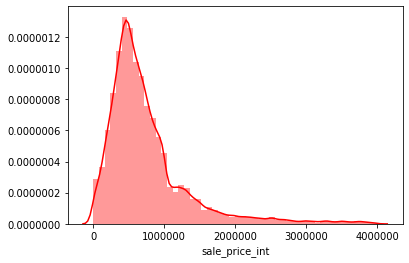

In [89]:
# Whole Dataset sales dist - new
sns.distplot(home_data['sale_price_int'],color = 'r')

In [90]:
#skewness and kurtosis
print("Skewness: %f" % home_data['sale_price_int'].skew())
print("Kurtosis: %f" % home_data['sale_price_int'].kurt())

Skewness: 2.259004
Kurtosis: 6.635920


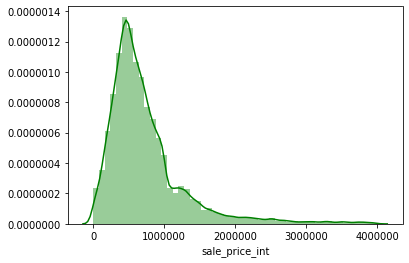

In [91]:
# Residential Dataset sales dist
sns.distplot(residential_data['sale_price_int'],color = 'g')

In [92]:
#skewness and kurtosis
print("Skewness: %f" % residential_data['sale_price_int'].skew())
print("Kurtosis: %f" % residential_data['sale_price_int'].kurt())

Skewness: 2.305449
Kurtosis: 7.237006


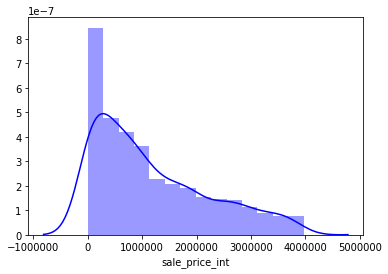

In [93]:
# Commercial Dataset sales dist
sns.distplot(commercial_data['sale_price_int'],color = 'b')

In [94]:
#skewness and kurtosis
print("Skewness: %f" % commercial_data['sale_price_int'].skew())
print("Kurtosis: %f" % commercial_data['sale_price_int'].kurt())

Skewness: 0.852578
Kurtosis: -0.307122


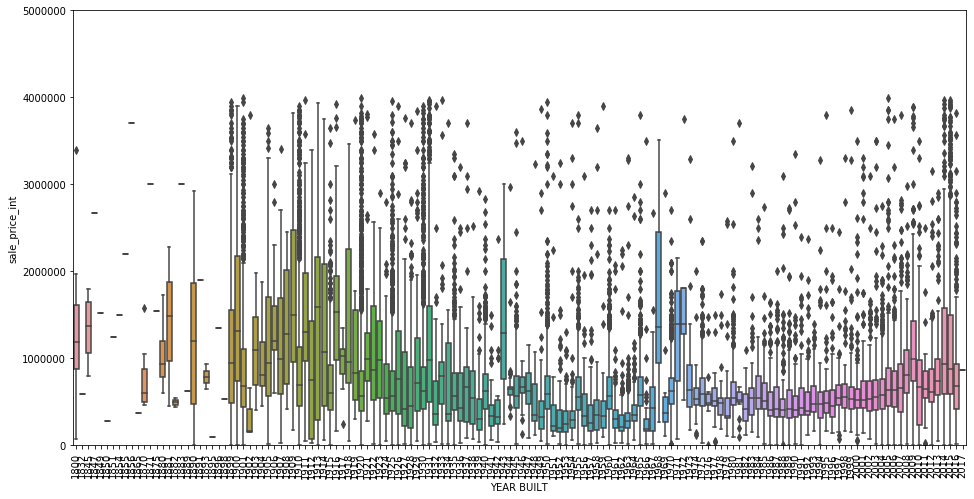

In [95]:
#box plot year built/saleprice
var = 'YEAR BUILT'
data = pd.concat([home_data['sale_price_int'], home_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="sale_price_int", data=data)
fig.axis(ymin=0, ymax=5000000);
plt.xticks(rotation=90);

In [96]:
# Create X - Choosing features I think would be most influential
features = ['RESIDENTIAL UNITS','COMMERCIAL UNITS', 'TOTAL UNITS',
       'gross_square_feet_int','BOROUGH','TAX CLASS AT TIME OF SALE','ZIP CODE','YEAR BUILT']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,test_size=0.2)
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
candidate_max_leaf_nodes = list(range(2,500))
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
leaf = []
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

for index,n in enumerate(candidate_max_leaf_nodes):
    k = get_mae(n, train_X, val_X, train_y, val_y)
    leaf.append(k) 
# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[leaf.index(min(leaf))]
print(best_tree_size)

# Specify Model
home_model = DecisionTreeRegressor(random_state=0,max_leaf_nodes=best_tree_size)

# Fit Model
home_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE specifying max leaf nodes {}".format(val_mae))

(27126, 8) (27126,)
(6782, 8) (6782,)
367
Validation MSE specifying max leaf nodes 248604.56045321957


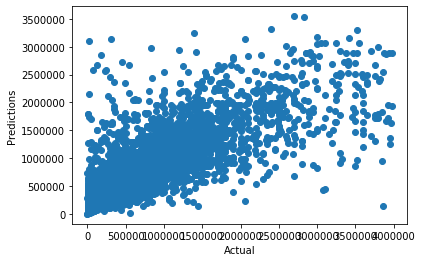

Validation MSE for Random Forest Model: 228238.16271399066
0.30401560786760556


In [97]:
## RANDOM FOREST
# Define the model

rf_model = RandomForestRegressor(random_state=0,n_estimators=10)

# fit model
rf_model.fit(train_X,train_y)

# Calculate the mean absolute error of Random Forest model on the validation data
val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_predictions, val_y)

plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE for Random Forest Model: {}".format(rf_val_mae))
print(rf_val_mae/avg_price)

In [88]:
# RIDGE
l = list(range(7000,10000))
home_model_CV = RidgeCV(alphas=l)
home_model = home_model_CV.fit(train_X,train_y)
print(home_model.alpha_)
val_predictions = home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

7000
Validation MSE 34.823354514236776
6.620740263019756e-05


In [89]:
#LASSO
home_model_CV = LassoCV(alphas=[3398,1],cv=5)
home_model = home_model_CV.fit(train_X,train_y)
print(home_model.alpha_)
val_predictions=home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

1
Validation MSE 0.010012481189815686
1.9036086060876017e-08


In [90]:
lm = linear_model.LinearRegression()
model = lm.fit(train_X, train_y)
val_predictions = lm.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

Validation MSE 1.4443893036266985e-10
2.7461244189116686e-16


In [76]:
# # NEURAL NET -- Tried doing a neural net, couldn't get it to work
# from keras.models import Sequential
# model = Sequential()
# from keras.layers import Dense
# from keras.losses import sparse_categorical_crossentropy
# from keras.optimizers import SGD
# model.add(Dense(units=64, activation='relu', input_dim=9))
# model.add(Dense(units=1, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])
# model.compile(loss=sparse_categorical_crossentropy,
#               optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
# # x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
# model.fit(train_X, train_y, epochs=5, batch_size=32)
# loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
''' Conclusions
More data about sales would help - other housing datasets
have 100+ predictors (Ames housing dataset) and even the 
cut down models using that data use ~20+ predictors whereas
our models only used 9 predictors we deemed useful out
of the entire dataset.'''